In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
epoch_key = "bon", 3, 2

In [4]:
animal, day, epoch = epoch_key
data_type, dim = "clusterless", "1D"

In [5]:
from src.load_data import load_data

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [6]:
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.position import EDGE_ORDER, EDGE_SPACING
from src.parameters import ANIMALS

is_training = data["position_info"].speed > 4
position = data["position_info"].loc[:, "linear_position"]
track_labels = data["position_info"].arm_name
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

(3729.0277, 4660.0197)

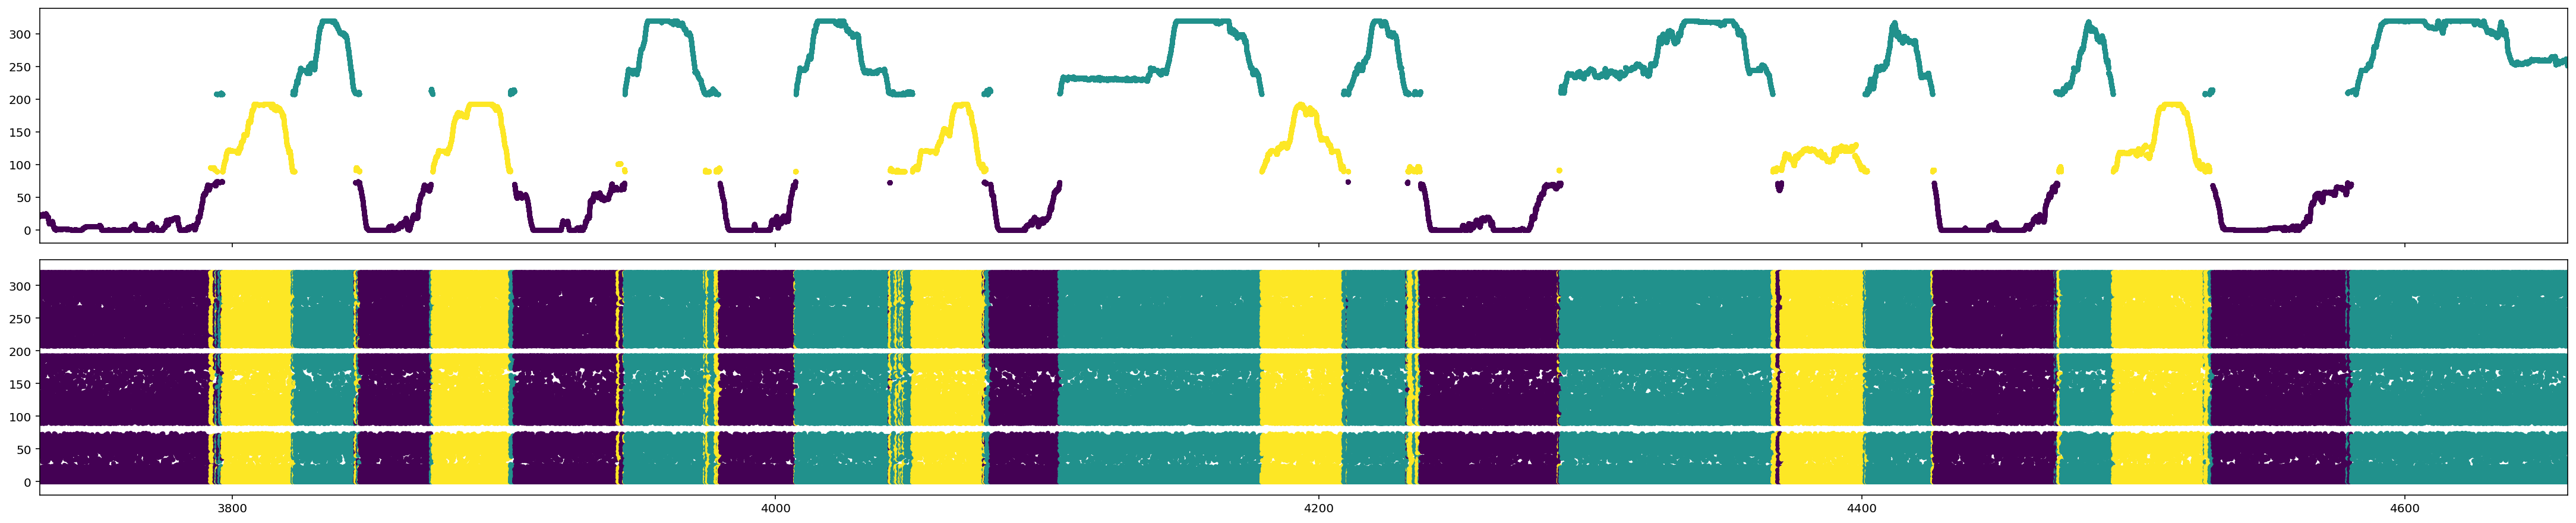

In [7]:
import sklearn.utils
import sklearn.preprocessing

enc = sklearn.preprocessing.OrdinalEncoder().fit(track_labels.values[:, np.newaxis])
label_ind = enc.transform(track_labels.values[:, np.newaxis]).squeeze()

fig, axes = plt.subplots(
    2, 1, figsize=(30, 6), sharex=True, sharey=True, constrained_layout=True
)
time = position.index / np.timedelta64(1, "s")
axes[0].scatter(time, position.values, c=label_ind, s=10)
axes[1].scatter(time, sklearn.utils.resample(position).values, c=label_ind, s=10)
plt.xlim((time.min(), time.max()))

In [8]:
import logging
import os
import sys
from argparse import ArgumentParser
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client
from loren_frank_data_processing import save_xarray
from loren_frank_data_processing.position import make_track_graph
from replay_trajectory_classification import (
    ClusterlessClassifier,
    SortedSpikesClassifier,
)
from scipy.ndimage import label
from tqdm.auto import tqdm

from src.analysis import (
    get_linear_position_order,
    get_place_field_max,
    get_replay_info,
    reshape_to_segments,
)
from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_neuron_place_field_2D_1D_position,
    plot_ripple_decode_1D,
    plot_ripple_decode_2D,
)

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def classify(
    position,
    classifier,
    data,
    is_training,
    track_graph,
    center_well_id,
    edge_order,
    edge_spacing,
    epoch_key,
    name="actual",
):
    animal, day, epoch = epoch_key
    data_type, dim = "clusterless", "1D"

    classifier.fit(
        position,
        data["multiunit"],
        is_training=is_training,
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=edge_order,
        edge_spacing=edge_spacing,
    )

    # Decode
    is_test = ~is_training

    test_groups = pd.DataFrame(
        {"test_groups": label(is_test.values)[0]}, index=is_test.index
    )
    immobility_results = []
    for _, df in tqdm(
        test_groups.loc[is_test].groupby("test_groups"), desc="immobility"
    ):
        start_time, end_time = df.iloc[0].name, df.iloc[-1].name
        test_multiunit = data["multiunit"].sel(time=slice(start_time, end_time))
        immobility_results.append(
            classifier.predict(test_multiunit, time=test_multiunit.time)
        )

    immobility_results = xr.concat(immobility_results, dim="time")

    results = [
        (
            immobility_results.sel(
                time=slice(df.start_time, df.end_time)
            ).assign_coords(time=lambda ds: ds.time - ds.time[0])
        )
        for _, df in data["ripple_times"].iterrows()
    ]

    results = xr.concat(results, dim=data["ripple_times"].index).assign_coords(
        state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
    )

    logging.info("Saving results...")
    save_xarray(
        os.path.join(PROCESSED_DATA_DIR, "shuffle"),
        epoch_key,
        results.drop(["causal_posterior"]),
        group=f"/{data_type}/{dim}/classifier/shuffle/{name}",
    )

    logging.info("Calculating replay_info...")
    ripple_times = data["ripple_times"].loc[:, ["start_time", "end_time"]]
    spikes = (
        ((data["multiunit"].sum("features") > 0) * 1.0)
        .to_dataframe(name="spikes")
        .unstack()
    )
    spikes.columns = data["tetrode_info"].tetrode_id
    ripple_spikes = reshape_to_segments(spikes, ripple_times)
    track_graph, _ = make_track_graph(epoch_key, ANIMALS)
    replay_info = get_replay_info(
        results,
        ripple_spikes,
        data["ripple_times"],
        data["position_info"],
        track_graph,
        SAMPLING_FREQUENCY,
        PROBABILITY_THRESHOLD,
        epoch_key,
        classifier,
    )

    logging.info("Saving replay_info...")
    epoch_identifier = f"{animal}_{day:02d}_{epoch:02d}_{data_type}_{dim}"
    replay_info_filename = os.path.join(
        PROCESSED_DATA_DIR, "shuffle", f"{epoch_identifier}_replay_info_{name}.csv"
    )
    replay_info.to_csv(replay_info_filename)

In [9]:
classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model,
    model_kwargs=model_kwargs,
)

classifier

ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'identity'],
                                                   ['uniform', 'uniform',
                                                    'uniform'],
                                                   ['random_walk', 'uniform',
                                                    'identity']],
                      discrete_transition_diag=0.98,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      occupancy_m

In [10]:
for shuffle_ind in range(50):
    classify(
        sklearn.utils.resample(position),
        classifier,
        data,
        is_training,
        track_graph,
        center_well_id,
        EDGE_ORDER,
        EDGE_SPACING,
        epoch_key,
        name=f"shuffle_{shuffle_ind:02d}",
    )

03-Mar-20 17:45:05 Fitting initial conditions...
03-Mar-20 17:45:06 Fitting state transition...
03-Mar-20 17:45:06 Fitting multiunits...


03-Mar-20 21:26:46 Saving results...
03-Mar-20 21:26:46 Calculating replay_info...
03-Mar-20 21:28:23 Saving replay_info...
03-Mar-20 21:28:23 Fitting initial conditions...
03-Mar-20 21:28:23 Fitting state transition...
03-Mar-20 21:28:24 Fitting multiunits...


04-Mar-20 01:09:25 Saving results...
04-Mar-20 01:09:25 Calculating replay_info...
04-Mar-20 01:10:59 Saving replay_info...
04-Mar-20 01:10:59 Fitting initial conditions...
04-Mar-20 01:10:59 Fitting state transition...
04-Mar-20 01:11:00 Fitting multiunits...


04-Mar-20 04:51:35 Saving results...
04-Mar-20 04:51:36 Calculating replay_info...
04-Mar-20 04:53:12 Saving replay_info...
04-Mar-20 04:53:12 Fitting initial conditions...
04-Mar-20 04:53:12 Fitting state transition...
04-Mar-20 04:53:13 Fitting multiunits...


04-Mar-20 08:34:11 Saving results...
04-Mar-20 08:34:11 Calculating replay_info...
04-Mar-20 08:35:46 Saving replay_info...
04-Mar-20 08:35:46 Fitting initial conditions...
04-Mar-20 08:35:46 Fitting state transition...
04-Mar-20 08:35:46 Fitting multiunits...


04-Mar-20 12:16:31 Saving results...
04-Mar-20 12:16:31 Calculating replay_info...
04-Mar-20 12:18:06 Saving replay_info...
04-Mar-20 12:18:06 Fitting initial conditions...
04-Mar-20 12:18:06 Fitting state transition...
04-Mar-20 12:18:07 Fitting multiunits...


04-Mar-20 15:58:53 Saving results...
04-Mar-20 15:58:54 Calculating replay_info...
04-Mar-20 16:00:31 Saving replay_info...
04-Mar-20 16:00:31 Fitting initial conditions...
04-Mar-20 16:00:31 Fitting state transition...
04-Mar-20 16:00:31 Fitting multiunits...


04-Mar-20 19:40:47 Saving results...
04-Mar-20 19:40:48 Calculating replay_info...
04-Mar-20 19:42:20 Saving replay_info...
04-Mar-20 19:42:20 Fitting initial conditions...
04-Mar-20 19:42:20 Fitting state transition...
04-Mar-20 19:42:21 Fitting multiunits...


04-Mar-20 23:22:57 Saving results...
04-Mar-20 23:22:58 Calculating replay_info...
04-Mar-20 23:24:33 Saving replay_info...
04-Mar-20 23:24:33 Fitting initial conditions...
04-Mar-20 23:24:33 Fitting state transition...
04-Mar-20 23:24:33 Fitting multiunits...


05-Mar-20 03:05:01 Saving results...
05-Mar-20 03:05:02 Calculating replay_info...
05-Mar-20 03:06:36 Saving replay_info...
05-Mar-20 03:06:36 Fitting initial conditions...
05-Mar-20 03:06:36 Fitting state transition...
05-Mar-20 03:06:36 Fitting multiunits...


05-Mar-20 06:47:05 Saving results...
05-Mar-20 06:47:05 Calculating replay_info...
05-Mar-20 06:48:41 Saving replay_info...
05-Mar-20 06:48:41 Fitting initial conditions...
05-Mar-20 06:48:41 Fitting state transition...
05-Mar-20 06:48:41 Fitting multiunits...


05-Mar-20 10:29:33 Saving results...
05-Mar-20 10:29:34 Calculating replay_info...
05-Mar-20 10:31:09 Saving replay_info...
05-Mar-20 10:31:09 Fitting initial conditions...
05-Mar-20 10:31:09 Fitting state transition...
05-Mar-20 10:31:10 Fitting multiunits...


05-Mar-20 14:11:58 Saving results...
05-Mar-20 14:11:59 Calculating replay_info...
05-Mar-20 14:13:33 Saving replay_info...
05-Mar-20 14:13:33 Fitting initial conditions...
05-Mar-20 14:13:33 Fitting state transition...
05-Mar-20 14:13:33 Fitting multiunits...


05-Mar-20 17:54:06 Saving results...
05-Mar-20 17:54:07 Calculating replay_info...
05-Mar-20 17:55:40 Saving replay_info...
05-Mar-20 17:55:40 Fitting initial conditions...
05-Mar-20 17:55:40 Fitting state transition...
05-Mar-20 17:55:41 Fitting multiunits...


05-Mar-20 21:36:24 Saving results...
05-Mar-20 21:36:24 Calculating replay_info...
05-Mar-20 21:38:00 Saving replay_info...
05-Mar-20 21:38:00 Fitting initial conditions...
05-Mar-20 21:38:00 Fitting state transition...
05-Mar-20 21:38:01 Fitting multiunits...


06-Mar-20 01:18:41 Saving results...
06-Mar-20 01:18:42 Calculating replay_info...
06-Mar-20 01:20:16 Saving replay_info...
06-Mar-20 01:20:16 Fitting initial conditions...
06-Mar-20 01:20:16 Fitting state transition...
06-Mar-20 01:20:16 Fitting multiunits...


06-Mar-20 05:00:53 Saving results...
06-Mar-20 05:00:54 Calculating replay_info...
06-Mar-20 05:02:29 Saving replay_info...
06-Mar-20 05:02:29 Fitting initial conditions...
06-Mar-20 05:02:29 Fitting state transition...
06-Mar-20 05:02:30 Fitting multiunits...


06-Mar-20 08:43:39 Saving results...
06-Mar-20 08:43:39 Calculating replay_info...
06-Mar-20 08:45:13 Saving replay_info...
06-Mar-20 08:45:13 Fitting initial conditions...
06-Mar-20 08:45:13 Fitting state transition...
06-Mar-20 08:45:14 Fitting multiunits...


06-Mar-20 12:25:27 Saving results...
06-Mar-20 12:25:28 Calculating replay_info...
06-Mar-20 12:27:01 Saving replay_info...
06-Mar-20 12:27:01 Fitting initial conditions...
06-Mar-20 12:27:01 Fitting state transition...
06-Mar-20 12:27:01 Fitting multiunits...


06-Mar-20 16:06:35 Saving results...
06-Mar-20 16:06:36 Calculating replay_info...
06-Mar-20 16:08:12 Saving replay_info...
06-Mar-20 16:08:12 Fitting initial conditions...
06-Mar-20 16:08:12 Fitting state transition...
06-Mar-20 16:08:12 Fitting multiunits...


06-Mar-20 19:48:04 Saving results...
06-Mar-20 19:48:05 Calculating replay_info...
06-Mar-20 19:49:40 Saving replay_info...
06-Mar-20 19:49:40 Fitting initial conditions...
06-Mar-20 19:49:40 Fitting state transition...
06-Mar-20 19:49:40 Fitting multiunits...


06-Mar-20 23:29:27 Saving results...
06-Mar-20 23:29:30 Calculating replay_info...
06-Mar-20 23:31:04 Saving replay_info...
06-Mar-20 23:31:04 Fitting initial conditions...
06-Mar-20 23:31:04 Fitting state transition...
06-Mar-20 23:31:04 Fitting multiunits...


07-Mar-20 03:10:45 Saving results...
07-Mar-20 03:10:46 Calculating replay_info...
07-Mar-20 03:12:20 Saving replay_info...
07-Mar-20 03:12:20 Fitting initial conditions...
07-Mar-20 03:12:20 Fitting state transition...
07-Mar-20 03:12:21 Fitting multiunits...


07-Mar-20 06:52:23 Saving results...
07-Mar-20 06:52:24 Calculating replay_info...
07-Mar-20 06:54:00 Saving replay_info...
07-Mar-20 06:54:00 Fitting initial conditions...
07-Mar-20 06:54:00 Fitting state transition...
07-Mar-20 06:54:00 Fitting multiunits...


07-Mar-20 10:33:50 Saving results...
07-Mar-20 10:33:51 Calculating replay_info...
07-Mar-20 10:35:25 Saving replay_info...
07-Mar-20 10:35:25 Fitting initial conditions...
07-Mar-20 10:35:25 Fitting state transition...
07-Mar-20 10:35:25 Fitting multiunits...


07-Mar-20 14:15:04 Saving results...
07-Mar-20 14:15:05 Calculating replay_info...
07-Mar-20 14:16:35 Saving replay_info...
07-Mar-20 14:16:35 Fitting initial conditions...
07-Mar-20 14:16:35 Fitting state transition...
07-Mar-20 14:16:35 Fitting multiunits...


07-Mar-20 17:56:38 Saving results...
07-Mar-20 17:56:38 Calculating replay_info...
07-Mar-20 17:58:07 Saving replay_info...
07-Mar-20 17:58:07 Fitting initial conditions...
07-Mar-20 17:58:07 Fitting state transition...
07-Mar-20 17:58:07 Fitting multiunits...


07-Mar-20 21:37:58 Saving results...
07-Mar-20 21:37:59 Calculating replay_info...
07-Mar-20 21:39:32 Saving replay_info...
07-Mar-20 21:39:32 Fitting initial conditions...
07-Mar-20 21:39:32 Fitting state transition...
07-Mar-20 21:39:33 Fitting multiunits...


08-Mar-20 01:19:21 Saving results...
08-Mar-20 01:19:21 Calculating replay_info...
08-Mar-20 01:20:57 Saving replay_info...
08-Mar-20 01:20:57 Fitting initial conditions...
08-Mar-20 01:20:57 Fitting state transition...
08-Mar-20 01:20:58 Fitting multiunits...


08-Mar-20 06:00:55 Saving results...
08-Mar-20 06:00:56 Calculating replay_info...
08-Mar-20 06:02:29 Saving replay_info...
08-Mar-20 06:02:29 Fitting initial conditions...
08-Mar-20 06:02:29 Fitting state transition...
08-Mar-20 06:02:29 Fitting multiunits...


08-Mar-20 09:42:13 Saving results...
08-Mar-20 09:42:14 Calculating replay_info...
08-Mar-20 09:43:48 Saving replay_info...
08-Mar-20 09:43:48 Fitting initial conditions...
08-Mar-20 09:43:48 Fitting state transition...
08-Mar-20 09:43:48 Fitting multiunits...


08-Mar-20 13:23:38 Saving results...
08-Mar-20 13:23:39 Calculating replay_info...
08-Mar-20 13:25:15 Saving replay_info...
08-Mar-20 13:25:15 Fitting initial conditions...
08-Mar-20 13:25:15 Fitting state transition...
08-Mar-20 13:25:15 Fitting multiunits...


08-Mar-20 17:05:09 Saving results...
08-Mar-20 17:05:09 Calculating replay_info...
08-Mar-20 17:06:42 Saving replay_info...
08-Mar-20 17:06:43 Fitting initial conditions...
08-Mar-20 17:06:43 Fitting state transition...
08-Mar-20 17:06:43 Fitting multiunits...


08-Mar-20 20:47:03 Saving results...
08-Mar-20 20:47:04 Calculating replay_info...
08-Mar-20 20:48:36 Saving replay_info...
08-Mar-20 20:48:36 Fitting initial conditions...
08-Mar-20 20:48:36 Fitting state transition...
08-Mar-20 20:48:36 Fitting multiunits...


09-Mar-20 00:28:37 Saving results...
09-Mar-20 00:28:37 Calculating replay_info...
09-Mar-20 00:30:10 Saving replay_info...
09-Mar-20 00:30:11 Fitting initial conditions...
09-Mar-20 00:30:11 Fitting state transition...
09-Mar-20 00:30:11 Fitting multiunits...


09-Mar-20 04:09:57 Saving results...
09-Mar-20 04:09:58 Calculating replay_info...
09-Mar-20 04:11:33 Saving replay_info...
09-Mar-20 04:11:33 Fitting initial conditions...
09-Mar-20 04:11:33 Fitting state transition...
09-Mar-20 04:11:33 Fitting multiunits...


09-Mar-20 07:51:31 Saving results...
09-Mar-20 07:51:32 Calculating replay_info...
09-Mar-20 07:53:05 Saving replay_info...
09-Mar-20 07:53:05 Fitting initial conditions...
09-Mar-20 07:53:05 Fitting state transition...
09-Mar-20 07:53:05 Fitting multiunits...


09-Mar-20 11:32:46 Saving results...
09-Mar-20 11:32:47 Calculating replay_info...
09-Mar-20 11:34:22 Saving replay_info...
09-Mar-20 11:34:22 Fitting initial conditions...
09-Mar-20 11:34:22 Fitting state transition...
09-Mar-20 11:34:22 Fitting multiunits...


09-Mar-20 15:14:05 Saving results...
09-Mar-20 15:14:06 Calculating replay_info...
09-Mar-20 15:15:39 Saving replay_info...
09-Mar-20 15:15:40 Fitting initial conditions...
09-Mar-20 15:15:40 Fitting state transition...
09-Mar-20 15:15:40 Fitting multiunits...


09-Mar-20 18:55:24 Saving results...
09-Mar-20 18:55:25 Calculating replay_info...
09-Mar-20 18:56:58 Saving replay_info...
09-Mar-20 18:56:58 Fitting initial conditions...
09-Mar-20 18:56:58 Fitting state transition...
09-Mar-20 18:56:59 Fitting multiunits...


09-Mar-20 22:36:32 Saving results...
09-Mar-20 22:36:35 Calculating replay_info...
09-Mar-20 22:38:09 Saving replay_info...
09-Mar-20 22:38:10 Fitting initial conditions...
09-Mar-20 22:38:10 Fitting state transition...
09-Mar-20 22:38:10 Fitting multiunits...


10-Mar-20 02:18:02 Saving results...
10-Mar-20 02:18:03 Calculating replay_info...
10-Mar-20 02:19:37 Saving replay_info...
10-Mar-20 02:19:37 Fitting initial conditions...
10-Mar-20 02:19:37 Fitting state transition...
10-Mar-20 02:19:38 Fitting multiunits...


10-Mar-20 05:59:13 Saving results...
10-Mar-20 05:59:14 Calculating replay_info...
10-Mar-20 06:00:46 Saving replay_info...
10-Mar-20 06:00:46 Fitting initial conditions...
10-Mar-20 06:00:46 Fitting state transition...
10-Mar-20 06:00:47 Fitting multiunits...


10-Mar-20 09:40:31 Saving results...
10-Mar-20 09:40:32 Calculating replay_info...
10-Mar-20 09:42:07 Saving replay_info...
10-Mar-20 09:42:07 Fitting initial conditions...
10-Mar-20 09:42:07 Fitting state transition...
10-Mar-20 09:42:07 Fitting multiunits...


10-Mar-20 13:21:59 Saving results...
10-Mar-20 13:22:00 Calculating replay_info...
10-Mar-20 13:23:33 Saving replay_info...
10-Mar-20 13:23:33 Fitting initial conditions...
10-Mar-20 13:23:33 Fitting state transition...
10-Mar-20 13:23:33 Fitting multiunits...


10-Mar-20 17:03:33 Saving results...
10-Mar-20 17:03:34 Calculating replay_info...
10-Mar-20 17:05:09 Saving replay_info...
10-Mar-20 17:05:09 Fitting initial conditions...
10-Mar-20 17:05:09 Fitting state transition...
10-Mar-20 17:05:09 Fitting multiunits...


10-Mar-20 20:44:59 Saving results...
10-Mar-20 20:45:00 Calculating replay_info...
10-Mar-20 20:46:33 Saving replay_info...
10-Mar-20 20:46:33 Fitting initial conditions...
10-Mar-20 20:46:33 Fitting state transition...
10-Mar-20 20:46:33 Fitting multiunits...


11-Mar-20 00:26:07 Saving results...
11-Mar-20 00:26:10 Calculating replay_info...
11-Mar-20 00:27:43 Saving replay_info...
11-Mar-20 00:27:43 Fitting initial conditions...
11-Mar-20 00:27:43 Fitting state transition...
11-Mar-20 00:27:44 Fitting multiunits...


11-Mar-20 04:07:38 Saving results...
11-Mar-20 04:07:39 Calculating replay_info...
11-Mar-20 04:09:14 Saving replay_info...
11-Mar-20 04:09:14 Fitting initial conditions...
11-Mar-20 04:09:14 Fitting state transition...
11-Mar-20 04:09:14 Fitting multiunits...


11-Mar-20 07:48:52 Saving results...
11-Mar-20 07:48:53 Calculating replay_info...
11-Mar-20 07:50:26 Saving replay_info...
11-Mar-20 07:50:26 Fitting initial conditions...
11-Mar-20 07:50:26 Fitting state transition...
11-Mar-20 07:50:27 Fitting multiunits...


11-Mar-20 11:30:00 Saving results...
11-Mar-20 11:30:01 Calculating replay_info...
11-Mar-20 11:31:34 Saving replay_info...
